In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../nonlin')
sys.path.append('../partion')
sys.path.append('../1D-difusion')

from aspen import aspen
from newton import newton

import partion
from partion import metrics1, metrics2, m1, m2, m3
import wrapper

from one_phase import one_phase
import numpy as np
import matplotlib.pyplot as plt

### Начальные условия и модель

In [2]:
def model(u):
    return np.array([u**2+1, 2*max(u, 0)])

class Diffusion():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx+1, 1))
        for i in range(Nx+1):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

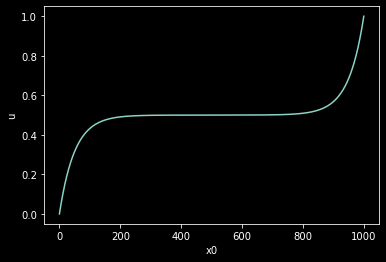

In [3]:
plt.style.use('dark_background')
# inital condition
Nx = 1000
Nt = 100
D = Diffusion(Nx, 0.9, 1, 0.5e-1, model=model)
bd1 = 0
bd2 = 1
x0 = np.arange(Nx)/(Nx-1)
x0 = np.sinh(20*(x0-0.5))
x0 /= np.max(x0)
x0 = (x0+1)/2
x0 = np.reshape(x0, (-1, 1))
plt.xlabel('x0')
plt.ylabel('u')
plt.plot(x0)

Такое начальное условие выбрано для динамики, позднее на графиках будет видно как решение меняется по времени

In [4]:
param = {
    'Nx': Nx, 
    'Nt': Nt,
}
nl_solver = newton(1e-2, kmax = 14, crit_abs = 1e-3)
solver_cl = one_phase(param, D, nl_solver)
X_cl, message, t_new = wrapper.calc(solver_cl, x0, bd1, bd2)

test started
verdict : OK
mean time : 67.82532143592834
mean newton iterations:  4.11


In [ ]:
Nd = 4
param = {
    'Nx': Nx, 
    'Nt': Nt
}
part = partion.partion_equally(Nx, Nd)
nl_solver = aspen(Nd, part, 1e-2, crit_abs = 1e-3)
solver_as = one_phase(param, D, nl_solver)
X, message, t_eq = wrapper.calc(solver_as, x0, bd1, bd2)

test started


In [ ]:
print(solver_as.timelog.gb_res, solver_cl.timelog.res)
print(solver_as.timelog.gb_jac, solver_cl.timelog.jac)
print(solver_as.timelog.lc_jac)
print(solver_as.timelog.lc_res)

### Графики решения

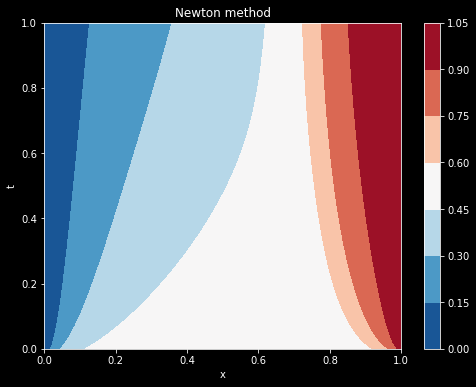

iters : [6.09 1.   1.   1.01]


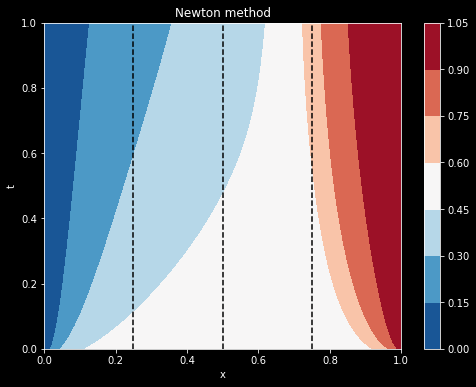

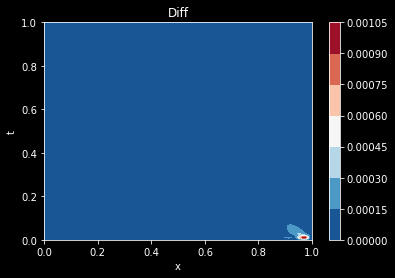

In [6]:
wrapper.show_res(solver_cl)
wrapper.show_res(solver_as)
x = np.linspace(0, 1, Nx)

plt.title('Diff')
plt.xlabel('x')
plt.ylabel('t')
t = solver_as.t
x_grid, t_grid = np.meshgrid(x, t)
cs = plt.contourf(x_grid, t_grid, (np.abs(X-X_cl)).T, cmap='RdBu_r')
cbar = plt.colorbar(cs)
plt.show()

Как видим а) присутсвует динамика по времени, имеющая локальный характер, б) решения двух алгоритмов отличаются в пределах погрешности

--time comparision--
newton : 67.82532143592834
aspen : 122.7082622051239


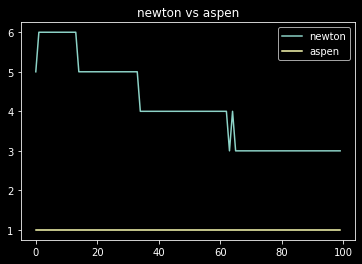

In [7]:
wrapper.compare([solver_cl, solver_as], ['newton', 'aspen'])

Хм, похоже что ускорения получилось добиться незначительного

Почти везде aspen справляется за одну иттерацию, когда метод Ньютона работает долго на начальных этапах задачи. Скорей всего, продолжи мы решения даже, вышли бы уже на почти стационарный участоток, где требуется мало иттераций

Во-первых, тут мы наблюдаем выделние домена с наибольшим число иттераций, во-вторых похоже что среднее число иттераций в нем превосходит среднее число иттераций в методе Ньютона, что еще раз подвтерждает версию о том, что ASPEN был эффективен на начальных этапах задачи. Вероятно, надо учиться делать динамические границы

### Тактики разбиения
На примере данной задачи будем тестить разные критерии разбиения на домены

### Две формулировки функции на минимизацию:

$$
	vol(\partial S_i) = \sum_{v \in V_i} \sum_{u \in \Gamma(v), u \notin V_i} {w(v, u)}
$$
Первый способ:
$$
\sum \frac{vol(\partial S_i)}{| V_i|} \rightarrow \min
$$
Второй способ:
$$
\sum \frac{vol(\partial S_i)}{vol(V_i)} \rightarrow \min
$$
где $vol(V_i) = \sum_{u, v \in V_i} w(u, v)$

##### Метод 1
$$
w(v, u) =  (|\frac{\partial R(u)}{\partial v}| + |\frac{\partial R(v)}{\partial u}|)
$$

[[151231.05684166  50566.75293961      0.         ...      0.
       0.              0.        ]
 [ 50566.75293961 101517.47102679  50851.02247368 ...      0.
       0.              0.        ]
 [     0.          50851.02247368 102086.59214202 ...      0.
       0.              0.        ]
 ...
 [     0.              0.              0.         ... 196997.6201028
   98765.82513007      0.        ]
 [     0.              0.              0.         ...  98765.82513007
  198266.12570976  99400.30195135]
 [     0.              0.              0.         ...      0.
   99400.30195135 199535.50295143]] [[1.51229553e+05 5.05682276e+04 6.90061875e-01 ... 2.02561858e-24
  1.34507834e-24 1.21698946e-22]
 [5.05682276e+04 1.01515961e+05 5.08517597e+04 ... 4.24465649e-25
  2.83514170e-25 3.62101140e-22]
 [6.90061875e-01 5.08517597e+04 1.02085383e+05 ... 1.27219752e-26
  1.14048822e-26 6.02249827e-22]
 ...
 [2.02561858e-24 4.24465649e-25 1.27219752e-26 ... 1.96997511e+05
  9.87654270e+04 6.42112376e+

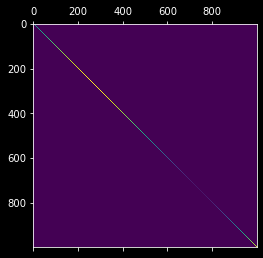

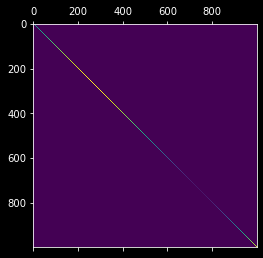

In [149]:
# Matrix of Weights
Jf = partion.precompute_Jf(solver_cl, X[:, 40], Nx)
func = lambda i, j: m1(solver_cl, Jf, i, j)
A = partion.adj_matrix(func, Nx, sc = 1)
B = partion.adj_matrix(func, Nx, sc = 2)
plt.matshow(A)
plt.matshow(B)
print(A, B)
#plt.show()

1.564778675113366


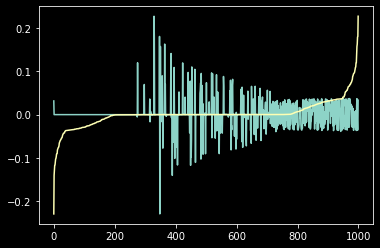

In [145]:
# spectral bisection

v2 = partion.spec_bis(A-np.diag(A), inv = True)
plt.plot(v2)
print(v2 @ np.ones(Nx))
plt.plot(np.sort(v2))

(533,)


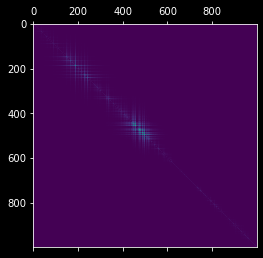

In [115]:
ind = np.argsort(v2)
Jf = partion.precompute_Jf(solver_cl, X[ind, 40], Nx)
func = lambda i, j: m1(solver_cl, Jf, i, j)
B_new = partion.adj_matrix(func, Nx, sc = 2)
plt.matshow(B_new)
dm1 = v2[v2 > 0]

print(dm1.shape)

In [75]:
# first - clustering approach
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(B)
cl = kmeans.labels_
bd_cl1 = [0]

for i in range(1, Nx):
    if cl[i-1] != cl[i]:
        bd_cl1.append(i)
bd_cl1.append(Nx)
bd_cl1 = np.array(bd_cl1)
print(bd_cl1)

[   0  234  363  841  939 1000]


In [17]:
# local search (Simulated annealing)
func = lambda borders: metrics2(borders, A)
borders = partion.partion_equally(Nx, Nd)

solver = partion.heat_1D()
bd1a, opt1a = wrapper.local_search(borders, func, solver)

--before--
[   0  250  500  750 1000] 2.19E-03
--after--
[   0  211  456  702 1000] 2.55E-03


In [18]:
# local search (Simulated annealing)
func = lambda borders: metrics2(borders, B)
borders = partion.partion_equally(Nx, Nd)

solver = partion.heat_1D()
bd1b, opt1b = wrapper.local_search(borders, func, solver)

--before--
[   0  250  500  750 1000] 2.76E-03
--after--
[   0  214  457  669 1000] 3.13E-03


In [20]:
Nd = 4
param = {
    'Nx': Nx, 
    'Nt': Nt
}
bd1 = 0
bd2 = 1
nl_solver = aspen(Nd, bd_cl1, 1e-2, crit_abs = 1e-3)
solver_as = one_phase(param, D, nl_solver)
X, message, t_cl1 = wrapper.calc(solver_as, x0, bd1, bd2)

nl_solver = aspen(Nd, bd1a, 1e-2, crit_abs = 1e-3)
solver_as = one_phase(param, D, nl_solver)
X, message, t_1a = wrapper.calc(solver_as, x0, bd1, bd2)

nl_solver = aspen(Nd, bd1b, 1e-2, crit_abs = 1e-3)
solver_as = one_phase(param, D, nl_solver)
X, message, t_1b = wrapper.calc(solver_as, x0, bd1, bd2)

test started
verdict : Not converged
mean time : 0.0
mean aspen iterations:  0.0
test started
verdict : OK
mean time : 68.537109375
mean aspen iterations:  1.0
test started
verdict : OK
mean time : 64.26015949249268
mean aspen iterations:  1.0


iters : [6.1  1.   1.   1.01]


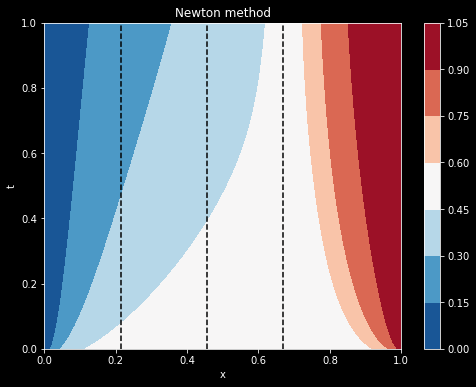

--time comparision--
newton : 62.68346667289734
aspen : 64.26015949249268


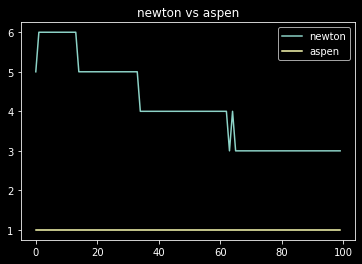

In [21]:
wrapper.show_res(solver_as)
wrapper.compare([solver_cl, solver_as], ['newton', 'aspen'])

Похоже, что работает метрика не супер хорошо

##### Метод 2 
$$
w(v, u) = |cov(u, v)|
$$
где u, v - столбцы по t

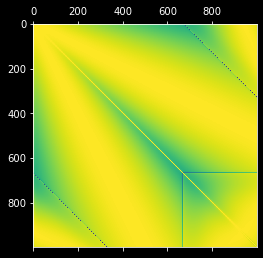

In [67]:
# Matrix of Weights
func = lambda i, j: m2(solver_cl, X, i, j)
A2 = partion.adj_matrix(func, Nx)
plt.matshow(A2)

plt.show()

In [68]:
print(A2)

[[1.         1.         0.50100277 ... 0.16497411 0.12482648 0.00163346]
 [1.         1.         0.50100277 ... 0.75826362 0.77002623 0.79503819]
 [0.50100277 0.50100277 1.         ... 0.88614355 0.89042061 0.89851746]
 ...
 [0.16497411 0.75826362 0.88614355 ... 1.         0.12482648 0.79503819]
 [0.12482648 0.77002623 0.89042061 ... 0.12482648 1.         0.00163346]
 [0.00163346 0.79503819 0.89851746 ... 0.79503819 0.00163346 1.        ]]


In [76]:
# first - clustering approach


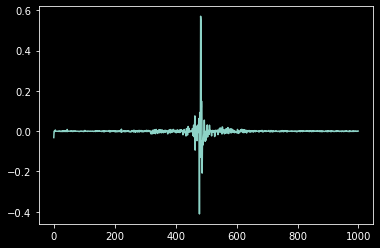

In [82]:
v = partion.spec_bis(A2)
plt.plot(v)

In [29]:
# local search (Simulated annealing)
func1 = lambda bd: m2(solver_cl, X, bd, Nt, 5)
ed = np.vectorize(func1)(np.arange(Nx))
weights = np.diag(ed , k =1) + np.diag(ed , k = -1)
func2 = lambda borders: metrics2(borders, func1, weights)
borders = partion.partion_equally(Nx, Nd)
solver = partion.heat_1D()
bd22, opt22 = wrapper.local_search(borders, func1, func2, solver)

TypeError: wraper() takes 3 positional arguments but 4 were given

test started
verdict : OK
mean time : 64.36829900741577
mean aspen iterations:  1.0
iters : [6.11 1.   1.   1.01]


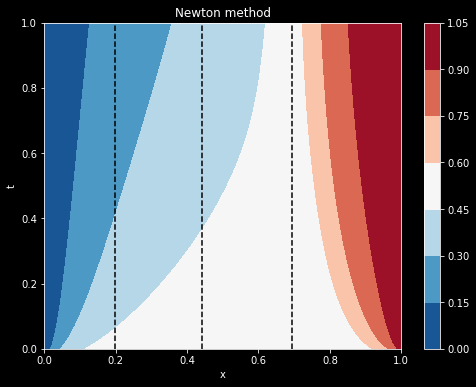

--time comparision--
newton : 63.71392226219177
aspen : 64.36829900741577


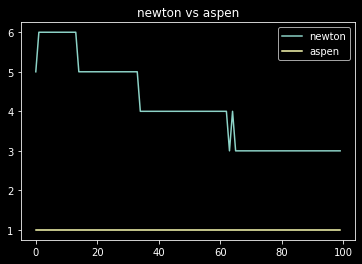

In [14]:
Nd = 4
param = {
    'Nx': Nx, 
    'Nt': Nt
}
nl_solver = aspen(Nd, bd21, 1e-2, crit_abs = 1e-3)
solver_as = one_phase(param, D, nl_solver)
X, message, t_m2 = wrapper.calc(solver_as, x0, bd1, bd2)

wrapper.show_res(solver_as)
wrapper.compare([solver_cl, solver_as], ['newton', 'aspen'])

##### Метод 3
$$
w(v, u) = \frac{|\frac{\partial (R(u)}{\partial u}|+ |\frac{\partial (R(v)}{\partial v}|}
{|\frac{\partial (R(u)}{\partial v}|+|\frac{\partial (R(v)}{\partial u}|}
$$

In [15]:
# local search (Simulated annealing)
func1 = lambda bd: m3(solver_cl, x0, bd, Nt)
func2 = lambda borders: metrics1(borders, func1)
borders = partion.partion_equally(Nx, Nd)
solver = partion.heat_1D()
bd31, opt31 = wrapper.local_search(borders, func1, func2, solver)

--before--
[   0  250  500  750 1000] 6.42E-02
--after--
[   0  194  437  692 1000] 6.59E-02


In [16]:
# local search (Simulated annealing)
func1 = lambda bd: m3(solver_cl, x0, bd, Nt)
ed = np.vectorize(func1)(np.arange(Nx))
weights = np.diag(ed , k =1) + np.diag(ed , k = -1)
func2 = lambda borders: metrics2(borders, func1, weights)
borders = partion.partion_equally(Nx, Nd)
solver = partion.heat_1D()
bd32, opt32 = wrapper.local_search(borders, func1, func2, solver)

--before--
[   0  250  500  750 1000] 1.61E-02
--after--
[   0  197  443  697 1000] 1.64E-02


test started
verdict : OK
mean time : 64.72341465950012
mean aspen iterations:  1.0
iters : [6.11 1.   1.   1.01]


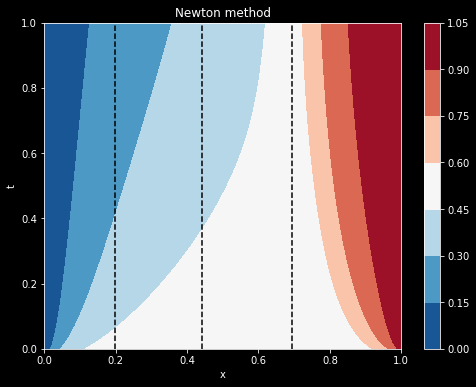

--time comparision--
newton : 63.71392226219177
aspen : 64.72341465950012


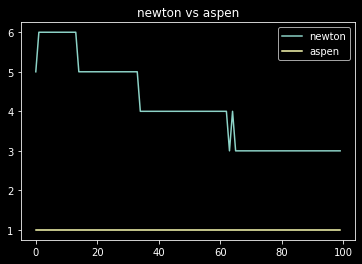

In [17]:
Nd = 4
param = {
    'Nx': Nx, 
    'Nt': Nt
}
nl_solver = aspen(Nd, bd21, 1e-2, crit_abs = 1e-3)
solver_as = one_phase(param, D, nl_solver)
X, message, t_m3 = wrapper.calc(solver_as, x0, bd1, bd2)

wrapper.show_res(solver_as)
wrapper.compare([solver_cl, solver_as], ['newton', 'aspen'])

In [18]:
print('---comparison---')
print('-eq-vs-m1-vs-m2-vs-m3-')

print('{:.4}'.format(t_eq),
     '{:.4}'.format(t_m1),
     '{:.4}'.format(t_m2),
     '{:.4}'.format(t_m3)
     )

---comparison---
-eq-vs-m1-vs-m2-vs-m3-
62.74 58.27 64.37 64.72


#### Вывод: лучшая метрика по критерию времени работы - m3

##### Тест на рандомных границах

In [27]:
import csv
gather_data = False
if gather_data:
    N = 150
    Nd = 4
    param = {
        'Nx': Nx, 
        'Nt': Nt
    }

    time = np.zeros(N)
    borders = np.zeros((Nd-1, N), dtype = 'int')
    num_of_alghs = 0

    for k in range(N):
        part = wrapper.generate_random(Nx, Nd)
        borders[:, k] = part[1:-1]
        nl_solver = aspen(Nd, part, 1e-2, crit_abs = 1e-3)
        solver_ts = one_phase(param, D, nl_solver)
        _, _, message, t = wrapper.calc(solver_ts, x0, bd1, bd2)
        if(message != 'OK'):
            continue
        time[k] = t
        num_of_alghs += 1
        if k % 10 == 0:
            print(k)      
    # save data
    name = './data/Nx={},Nt={},Nd={}.csv'.format(Nx, Nt, Nd)
    filt = time > 0
    with open(name, 'a') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerows(borders[:, filt])
        writer.writerow(time[filt])
else:
    name = './data/Nx={},Nt={},Nd={}.csv'.format(Nx, Nt, Nd)
    with open(name, 'r') as csvfile:
        reader = csv.reader(csvfile)
        data = []
        for row in reader:
            data.append(row)        
        borders = np.array(data[0:Nd-1], dtype='int')
        time = np.array(data[Nd-1], dtype= 'float')
        num_of_alghs = np.sum(time > 0)

In [28]:
print('Numner og alghorithms that converged:', num_of_alghs)
print('mean time :', np.sum(time)/num_of_alghs)
sq_cov = np.sqrt(np.sum(time**2)/num_of_alghs-(np.sum(time)/num_of_alghs)**2)
print('sqrt cov :', np.sqrt(np.sum(time**2)/num_of_alghs-(np.sum(time)/num_of_alghs)**2))

Numner og alghorithms that converged: 124
mean time : 73.19107317539954
sqrt cov : 15.016313974396432


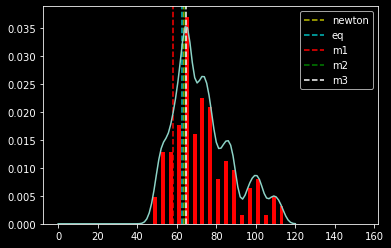

63.71392226219177 62.74007272720337 58.26623320579529 64.36829900741577 64.72341465950012


In [29]:
from scipy.stats import gaussian_kde
from scipy.integrate import quad

width = 4
win = np.arange(5, 155, width)
y = []
for x in win:
    mask = ((time < x+width/2) & (time > (x - width/2)))
    y.append(np.sum(mask)/ num_of_alghs/5)
    
plt.bar(win, y, width=width*0.5, color = 'r')
bw = 1/(1.06*sq_cov)*num_of_alghs**(1/5)
filt = time > 0
kernel = gaussian_kde(time[filt], bw_method=bw)

plt.axvline(t_new, label='newton', linestyle ='--', color='y')
plt.axvline(t_eq, label='eq', linestyle ='--', color='c')
plt.axvline(t_m1, label='m1', linestyle ='--', color ='r')
plt.axvline(t_m2, label='m2', linestyle ='--', color ='g')
plt.axvline(t_m3, label='m3', linestyle ='--', color ='w')

plt.plot(np.linspace(0, 120, 100), kernel(np.linspace(0, 120, 100)))
#plt.xlim((0, 45))
plt.legend()
plt.show()

print(t_new, t_eq, t_m1, t_m2, t_m3)

In [30]:
# we will estimate the efficency by function of distibution
p_eq, err_eq = quad(kernel, 0, t_eq)
print('equally partion : {}'.format(p_eq))
p_m1, err_m1 = quad(kernel, 0, t_m1)
print('m1 partion : {}'.format(p_m1))
p_m2, err_m2 = quad(kernel, 0, t_m2)
print('m2 partion : {}'.format(p_m2))
p_m3, err_m3 = quad(kernel, 0, t_m3)
print('m3 partion : {}'.format(p_m3))

equally partion : 0.2621897705863231
m1 partion : 0.14788846915216836
m2 partion : 0.3176105156431691
m3 partion : 0.33021837130338705


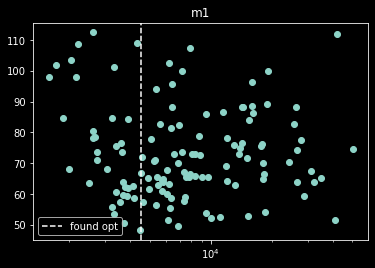

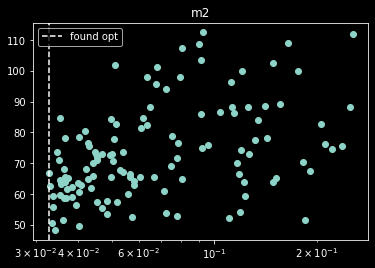

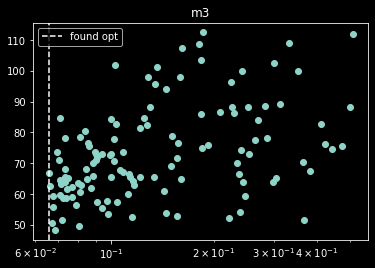

In [32]:
filt = time > 0
m1_list = []
m2_list = []
m3_list = []

fu1 = lambda bd: m1(solver_cl, x0, bd)
func1 = lambda borders: metrics1(borders, fu1)

fu2 = lambda bd: m2(solver_cl, X, bd, Nt, 10)
func2 = lambda borders: metrics1(borders, fu2)

fu3 = lambda bd: m3(solver_cl, x0, bd, Nt)
func3 = lambda borders: metrics1(borders, fu3)

for domain in borders[:, filt].T:
    part = np.concatenate(([0], domain, [Nx]), axis = 0)
    m1_list.append(func1(part))
    m2_list.append(func2(part))
    m3_list.append(func3(part))

m1_arr = np.array(m1_list)
m2_arr = np.array(m2_list)
m3_arr = np.array(m3_list)

plt.title('m1')
plt.scatter(m1_arr, time[filt])
plt.axvline(opt11, linestyle='--', label='found opt')
plt.legend()
plt.xscale('log')
plt.savefig('m1', dpi = 120)
plt.show()
plt.title('m2')
plt.axvline(opt21, linestyle='--', label='found opt')
plt.legend()
plt.scatter(m2_arr, time[filt])
plt.xscale('log')
plt.savefig('m2', dpi = 120)
plt.show()
plt.title('m3')
plt.axvline(opt31, linestyle='--', label='found opt')
plt.legend()
plt.scatter(m3_arr, time[filt])
plt.xscale('log')
plt.savefig('m3', dpi = 120)
plt.show()


In [24]:
cov_m1 = np.cov(np.stack((time[filt], m1_arr) , axis = 0))

print('---cov_m (time, m1_value)---')
print(cov_m1)
print('---cov(time, m1_value) / sqrt(var(m1_value)*var(time))---')
print('m1 :', cov_m1[0, 1]/np.sqrt(cov_m1[1, 1])/np.sqrt(cov_m1[0, 0]))

cov_m2 = np.cov(np.stack((time[filt], m2_arr) , axis = 0))

print('---cov_m (time, m2_value)---')
print(cov_m2)
print('---cov(time, m2_value) / sqrt(var(m2_value)*var(time))---')
print('m2 :', cov_m2[0, 1]/np.sqrt(cov_m2[1, 1])/np.sqrt(cov_m2[0, 0]))

cov_m3 = np.cov(np.stack((time[filt], m3_arr) , axis = 0))

print('---cov_m (time, m3_value)---')
print(cov_m3)
print('---cov(time, m2_value) / sqrt(var(m2_value)*var(time))---')
print('m3 :', cov_m3[0, 1]/np.sqrt(cov_m3[1, 1])/np.sqrt(cov_m3[0, 0]))


---cov_m (time, m1_value)---
[[2.27322935e+02 2.48060036e+03]
 [2.48060036e+03 8.37980500e+07]]
---cov(time, m1_value) / sqrt(var(m1_value)*var(time))---
m1 : 0.017972902546726954
---cov_m (time, m2_value)---
[[2.27322935e+02 2.99180260e-01]
 [2.99180260e-01 2.73668323e-03]]
---cov(time, m2_value) / sqrt(var(m2_value)*var(time))---
m2 : 0.3793141490532415
---cov_m (time, m3_value)---
[[2.27322935e+02 6.00270195e-01]
 [6.00270195e-01 1.09639165e-02]]
---cov(time, m2_value) / sqrt(var(m2_value)*var(time))---
m3 : 0.38022642166560594


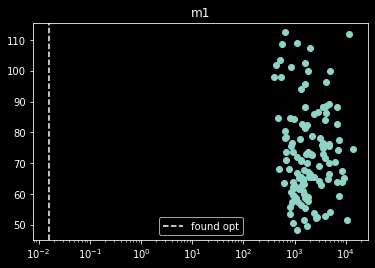

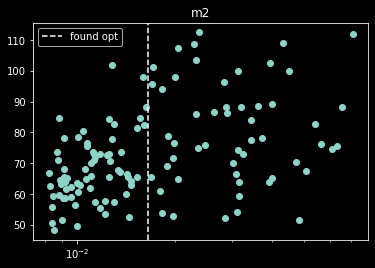

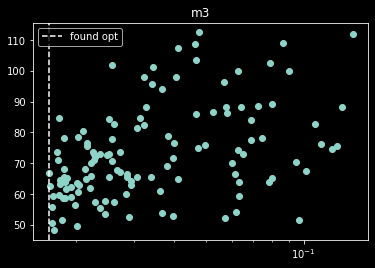

In [25]:
filt = time > 0
m1_list = []
m2_list = []
m3_list = []

fu1 = lambda bd: m1(solver_cl, x0, bd)
ed = np.vectorize(fu1)(np.arange(Nx))
weights = np.diag(ed , k =1) + np.diag(ed , k = -1)
func1 = lambda borders: metrics2(borders, fu1, weights)

fu2 = lambda bd: m2(solver_cl, X, bd, Nt, 10)
ed = np.vectorize(fu2)(np.arange(Nx))
weights = np.diag(ed , k =1) + np.diag(ed , k = -1)
func2 = lambda borders: metrics2(borders, fu2, weights)

fu3 = lambda bd: m3(solver_cl, x0, bd, Nt)
ed = np.vectorize(fu3)(np.arange(Nx))
weights = np.diag(ed , k =1) + np.diag(ed , k = -1)
func3 = lambda borders: metrics2(borders, fu3, weights)

for domain in borders[:, filt].T:
    part = np.concatenate(([0], domain, [Nx]), axis = 0)
    m1_list.append(func1(part))
    m2_list.append(func2(part))
    m3_list.append(func3(part))

m1_arr = np.array(m1_list)
m2_arr = np.array(m2_list)
m3_arr = np.array(m3_list)

plt.title('m1')
plt.scatter(m1_arr, time[filt])
plt.axvline(opt12, linestyle='--', label='found opt')
plt.legend()
plt.xscale('log')
plt.show()
plt.title('m2')
plt.axvline(opt22, linestyle='--', label='found opt')
plt.legend()
plt.scatter(m2_arr, time[filt])
plt.xscale('log')
plt.show()
plt.title('m3')
plt.axvline(opt32, linestyle='--', label='found opt')
plt.legend()
plt.scatter(m3_arr, time[filt])
plt.xscale('log')
plt.show()


In [26]:
cov_m1 = np.cov(np.stack((time[filt], m1_arr) , axis = 0))

print('---cov_m (time, m1_value)---')
print(cov_m1)
print('---cov(time, m1_value) / sqrt(var(m1_value)*var(time))---')
print('m1 :', cov_m1[0, 1]/np.sqrt(cov_m1[1, 1])/np.sqrt(cov_m1[0, 0]))

cov_m2 = np.cov(np.stack((time[filt], m2_arr) , axis = 0))

print('---cov_m (time, m2_value)---')
print(cov_m2)
print('---cov(time, m2_value) / sqrt(var(m2_value)*var(time))---')
print('m2 :', cov_m2[0, 1]/np.sqrt(cov_m2[1, 1])/np.sqrt(cov_m2[0, 0]))

cov_m3 = np.cov(np.stack((time[filt], m3_arr) , axis = 0))

print('---cov_m (time, m3_value)---')
print(cov_m3)
print('---cov(time, m2_value) / sqrt(var(m2_value)*var(time))---')
print('m3 :', cov_m3[0, 1]/np.sqrt(cov_m3[1, 1])/np.sqrt(cov_m3[0, 0]))


---cov_m (time, m1_value)---
[[2.27322935e+02 9.69904546e+02]
 [9.69904546e+02 6.00614554e+06]]
---cov(time, m1_value) / sqrt(var(m1_value)*var(time))---
m1 : 0.026248799288523993
---cov_m (time, m2_value)---
[[2.27322935e+02 7.89477090e-02]
 [7.89477090e-02 1.96439972e-04]]
---cov(time, m2_value) / sqrt(var(m2_value)*var(time))---
m2 : 0.3735966492524422
---cov_m (time, m3_value)---
[[2.27322935e+02 1.58392493e-01]
 [1.58392493e-01 7.87013261e-04]]
---cov(time, m2_value) / sqrt(var(m2_value)*var(time))---
m3 : 0.3744742344819755
